# IMPORTING NECESSARY LIBRARIES

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

import os
import time
import shutil
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import keras
import imutils
import gc
import re
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
from PIL import Image

import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
from keras.models import Sequential, Model, load_model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Activation, Dropout
import keras.backend as K
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D, Flatten, GlobalAveragePooling2D, AveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from imutils.video import VideoStream

Mounting Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# LOADING DATASET

In [ ]:
# Unzip the face mask dataset to train the model. 
!unzip '/content/gdrive/MyDrive/Computer Vision/Project/Dataset/FaceMask.zip'

#load the video datasets from drive.
shutil.copyfile('/content/gdrive/MyDrive/Computer Vision/Project/Dataset/video dataset 1.mp4', '/content/videoDataset1.mp4')
shutil.copyfile('/content/gdrive/MyDrive/Computer Vision/Project/Dataset/Video Dataset 2.mp4', '/content/videoDataset2.mp4')

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/train/without_mask/1777.jpg  
  inflating: Dataset/train/without_mask/1778.jpg  
  inflating: Dataset/train/without_mask/1779.jpg  
  inflating: Dataset/train/without_mask/178.jpg  
  inflating: Dataset/train/without_mask/1780.jpg  
  inflating: Dataset/train/without_mask/1781.jpg  
  inflating: Dataset/train/without_mask/1782.jpg  
  inflating: Dataset/train/without_mask/1783.jpg  
  inflating: Dataset/train/without_mask/1784.jpg  
  inflating: Dataset/train/without_mask/1785.jpg  
  inflating: Dataset/train/without_mask/1786.jpg  
  inflating: Dataset/train/without_mask/1787.jpg  
  inflating: Dataset/train/without_mask/1788.jpg  
  inflating: Dataset/train/without_mask/1789.jpg  
  inflating: Dataset/train/without_mask/179.jpg  
  inflating: Dataset/train/without_mask/1790.jpg  
  inflating: Dataset/train/without_mask/1791.jpg  
  inflating: Dataset/train/without_mask/1792.jpg  
  inflating: Dataset/train/withou

'/content/videoDataset2.mp4'

# FACE MASK DETECTION

Initializing some constants

In [ ]:
path = '/content/Dataset/'
train_path = '/content/Dataset/train/'
test_path = '/content/Dataset/test/'
img_size = 224
batch_size = 32

OpenCv SSD constants

In [ ]:
caffeModel = "/content/gdrive/MyDrive/Computer Vision/Project/Face mask/res10_300x300_ssd_iter_140000.caffemodel"
prototxtPath = "/content/gdrive/MyDrive/Computer Vision/Project/Face mask/deploy.prototxt.txt"

MobileNetV2 Model Architecture

In [ ]:
def facemask_model():
  mobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size,img_size,3))
  mobileNet = Model(mobileNet.input, mobileNet.output)

  for layer in mobileNet.layers:
    layer.trainable = False

  model = Sequential()
  model.add(mobileNet)
  model.add(AveragePooling2D(pool_size=(7, 7)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation="softmax"))

  epochs = 80
  lr = 0.0001
  adam = Adam(learning_rate=lr, decay=lr/epochs)
  model.compile(adam, 
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model

training the MobileNetV2 model

In [ ]:
def facemask_train():
  # load the model
  model = facemask_model()
  model.summary()

  
  train_datagen = ImageDataGenerator(rescale=1./255)
  train_generator = train_datagen.flow_from_directory(
          train_path,
          target_size=(img_size, img_size),
          batch_size=batch_size,
          shuffle=True,
          class_mode='categorical')

  test_datagen = ImageDataGenerator(rescale=1./255)  
  test_generator = test_datagen.flow_from_directory(
          test_path,
          target_size=(img_size, img_size),
          batch_size=batch_size,
          class_mode='categorical',
          shuffle=False)

  # train the model
  history = model.fit(train_generator, batch_size=batch_size, epochs=10, shuffle=True)

  # evaluate the model performance on test data.
  loss, accuracy = model.evaluate(test_generator)
  print("Model testing accuracy - ", accuracy, "\n")

  # saving the model
  model.save('/content/faceMask', save_format="h5")
  return model

Detecting faces in each frame

In [ ]:
def detect_and_predict_mask(frame, faceNet, maskModel):
  (h, w) = frame.shape[:2]
  # construct blob from the frame  with a dimension of 300x300
  blob = cv2.dnn.blobFromImage(frame, 1, (300,300),(104, 117, 123))

	# passing the blob to obtain the face detections.
  faceNet.setInput(blob)
  detections = faceNet.forward()
  
  faces = []
  locs = []
  preds = []

  
	# detections
  for i in range(0, detections.shape[2]):
		# confidence for each detection.
    confidence = detections[0, 0, i, 2]

		# setting a threshold value.
    if confidence > 0.5:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
      
      face = frame[startY:endY, startX:endX]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (224, 224))
      face = img_to_array(face)
      face = preprocess_input(face)

			# append face and bounding boxes to their respective lists
      faces.append(face)
      locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
  if len(faces) > 0:
    faces = np.array(faces, dtype="float32")
    preds = maskModel.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
  return (locs, preds)

For each frame predictions are done using MobileNetV2 and appropriate bounding boxes are applied.

In [ ]:
def getFrame(sec, count, vs, maskModel, faceNet):
    vs.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,frame = vs.read()
    if hasFrames:
      # detect faces with mask or not
      #dividing each frame into 3*4 subframe matrix 
      rows = 3 
      cols = 4

      height, width, ch = frame.shape
      roi_height = int(height / rows)
      roi_width = int(width / cols)

      images = []

      for x in range(0, rows):
        for y in range(0,cols):
          tmp_image=frame[x*roi_height:(x+1)*roi_height, y*roi_width:(y+1)*roi_width]
          images.append(tmp_image)

      for x in range(0, rows):
        for y in range(0, cols):
          (locs, preds) = detect_and_predict_mask(images[x*cols+y], faceNet, maskModel)
          for (box, pred) in zip(locs, preds):
            # unpack the bounding box and predictions
            (startX, startY, endX, endY) = box
            (mask, withoutMask) = pred

            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
              
            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            # display the label and bounding box rectangle on the output
            # frame
            cv2.putText(images[x*cols+y], label, (startX, startY - 10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.45, color, 1)
            cv2.rectangle(images[x*cols+y], (startX, startY), (endX, endY), color, 1)
      cv2.imwrite("/content/faceMask_output_images/"+str(count)+".png", frame)     # save frame as JPG file
      key = cv2.waitKey(1) & 0xFF
    return hasFrames

Detecting for a single frame

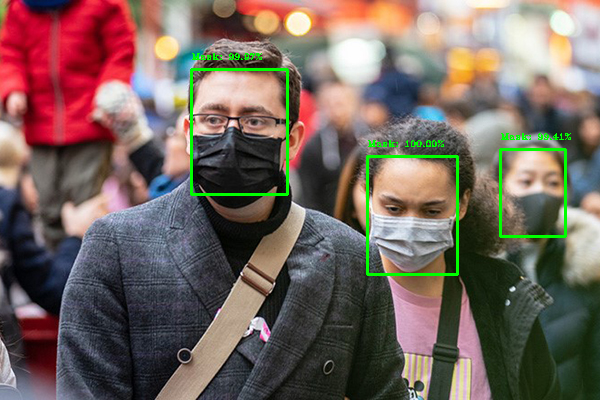

-1

In [ ]:
maskModel = load_model('/content/faceMask')
faceNet = cv2.dnn.readNetFromCaffe(prototxtPath, caffeModel)
frame = cv2.imread('/content/coronavirus-economy-teaser.jpg')


n_rows = 1
n_images_per_row = 2

height, width, ch = frame.shape
roi_height = int(height / n_rows)
roi_width = int(width / n_images_per_row)

images = []

for x in range(0, n_rows):
    for y in range(0,n_images_per_row):
        tmp_image=frame[x*roi_height:(x+1)*roi_height, y*roi_width:(y+1)*roi_width]
        images.append(tmp_image)

# Display the resulting sub-frame
for x in range(0, n_rows):
  for y in range(0, n_images_per_row):
    (locs, preds) = detect_and_predict_mask(images[x*n_images_per_row+y], faceNet, maskModel)
    for (box, pred) in zip(locs, preds):
      # unpack the bounding box and predictions
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

      # determine the class label and color we'll use to draw
      # the bounding box and text
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        
      # include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

      # display the label and bounding box rectangle on the output
      
      cv2.putText(images[x*n_images_per_row+y], label, (startX, startY - 10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.45, color, 1)
      cv2.rectangle(images[x*n_images_per_row+y], (startX, startY), (endX, endY), color, 2)

# show the output image
cv2_imshow(frame)
cv2.waitKey(0)

main function for face mask detection

In [ ]:
def facemaskDetection(maskModel, faceNet):
  os.mkdir('faceMask_output_images')
  
  # Initialize the video stream
  vs = cv2.VideoCapture('/content/videoDataset2.mp4')
  
  sec = 0
  frameRate = 0.04 # 25 fps
  count=1
  success = getFrame(sec, count, vs, maskModel, faceNet)
  while success:
      count = count + 1
      sec = sec + frameRate
      sec = round(sec, 2)
      success = getFrame(sec, count, vs, maskModel, faceNet)
  # cleanup
  cv2.destroyAllWindows()

All function calls from here for face mask detection

In [ ]:
maskModel = facemask_train()
faceNet = cv2.dnn.readNetFromCaffe(prototxtPath, caffeModel)
facemaskDetection(maskModel, faceNet)
print("Video Frames have been saved in the faceMask_output_images folder")

Video Frames have been saved in the faceMask_output_images folder


Converting generated face mask frames into a video

In [ ]:
#Convert frames to video
fps=25
image_folder='/content/faceMask_output_images'
image_files = os.listdir(image_folder)
image_files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in range(len(image_files)):
  image_files[i] = image_folder + str('/') + image_files[i]

clip = ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('/content/interVideo.mp4')

[MoviePy] >>>> Building video /content/interVideo.mp4
[MoviePy] Writing video /content/interVideo.mp4


100%|██████████| 1326/1326 [03:51<00:00,  5.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/interVideo.mp4 



# SOCIAL DISTANCING

function for detecting people in each frame

In [ ]:
def detect_people(frame, yoloNet, layer):
  (H, W) = frame.shape[:2]
  blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (320, 320), swapRB=True)

  # pass the blob through the network and obtain the face detections
  yoloNet.setInput(blob)
  detections = yoloNet.forward(layers)

  boxes = []
  centroids = []
  confidences = []

  for output in detections:
    # loop over each of the detections
    for detection in output:
      scores = detection[5:]
      classID = np.argmax(scores)
      confidence = scores[classID]
      if classID == 0 and confidence > 0.5:
        box = detection[0:4] * np.array([W, H, W, H])
        (centerX, centerY, width, height) = box.astype("int")

        # use the center (x, y)-coordinates to derive the top
        # and and left corner of the bounding box
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))

        # update our list of bounding box coordinates,
        # centroids, and confidences
        boxes.append([x, y, int(width), int(height)])
        centroids.append((centerX, centerY))
        confidences.append(float(confidence))

  idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.5)

  results = []
  if len(idxs) > 0:
      # loop over the indexes we are keeping
      for i in idxs.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # results list to consist of the person
        # prediction probability, bounding box coordinates,
        # and the centroid
        r = (confidences[i], (x, y, x + w, y + h), centroids[i])
        results.append(r)
  return results

Calculates distance between each person to check social distancing

In [ ]:
def euclideanDistance(frame, count):
    results = detect_people(frame, yoloNet, layers)
    centroids = np.array([r[2] for r in results])
    D = dist.cdist(centroids, centroids, metric="euclidean")   # a matrix
    violate = set()
    MIN_DISTANCE = 100
    for i in range(0, D.shape[0]):                # considering the upper half matrix
      for j in range(i + 1, D.shape[1]):
        if D[i, j] < MIN_DISTANCE:
          violate.add(i)
          violate.add(j)

    for (i, (prob, bbox, centroid)) in enumerate(results):
      (startX, startY, endX, endY) = bbox
      (cX, cY) = centroid
      color = (0, 255, 0)
      
      if i in violate:
        color = (0, 0, 255)
      
      cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
      label = "Total Voilations : " + str(len(violate))
      cv2.putText(frame, label, (30, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5, (0, 0, 255), 2)
    cv2.imwrite("/content/final_images/"+str(count)+".png", frame)     # save frame as JPG file

All function calls for socail distancing from here.

In [ ]:
os.mkdir('final_images')

weightsPath = '/content/gdrive/MyDrive/Computer Vision/Project/Social Distancing/yolov3.weights'
configPath = '/content/gdrive/MyDrive/Computer Vision/Project/Social Distancing/yolov3.cfg'

yoloNet = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

layers = yoloNet.getLayerNames()
layers = [layers[i[0] - 1] for i in yoloNet.getUnconnectedOutLayers()]

image_folder='/content/faceMask_output_images'
image_files = os.listdir(image_folder)
image_files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in range(len(image_files)):
  image_files[i] = image_folder + str('/') + image_files[i]

count = 1
for image in image_files:
  euclideanDistance(cv2.imread(image), count)
  count += 1

Converting the final frames into a video

In [ ]:
#Convert frames to video
fps=25
image_folder='/content/final_images'
image_files = os.listdir(image_folder)
image_files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in range(len(image_files)):
  image_files[i] = image_folder + str('/') + image_files[i]

clip = ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('/content/FM&SD.mp4')

[MoviePy] >>>> Building video /content/FM&SD.mp4
[MoviePy] Writing video /content/FM&SD.mp4


100%|██████████| 1326/1326 [04:09<00:00,  5.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/FM&SD.mp4 



For running a single image.

In [ ]:
weightsPath = '/content/gdrive/MyDrive/Computer Vision/Project/Social Distancing/yolov3.weights'
configPath = '/content/gdrive/MyDrive/Computer Vision/Project/Social Distancing/yolov3.cfg'

yoloNet = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

layers = yoloNet.getLayerNames()
layers = [layers[i[0] - 1] for i in yoloNet.getUnconnectedOutLayers()]

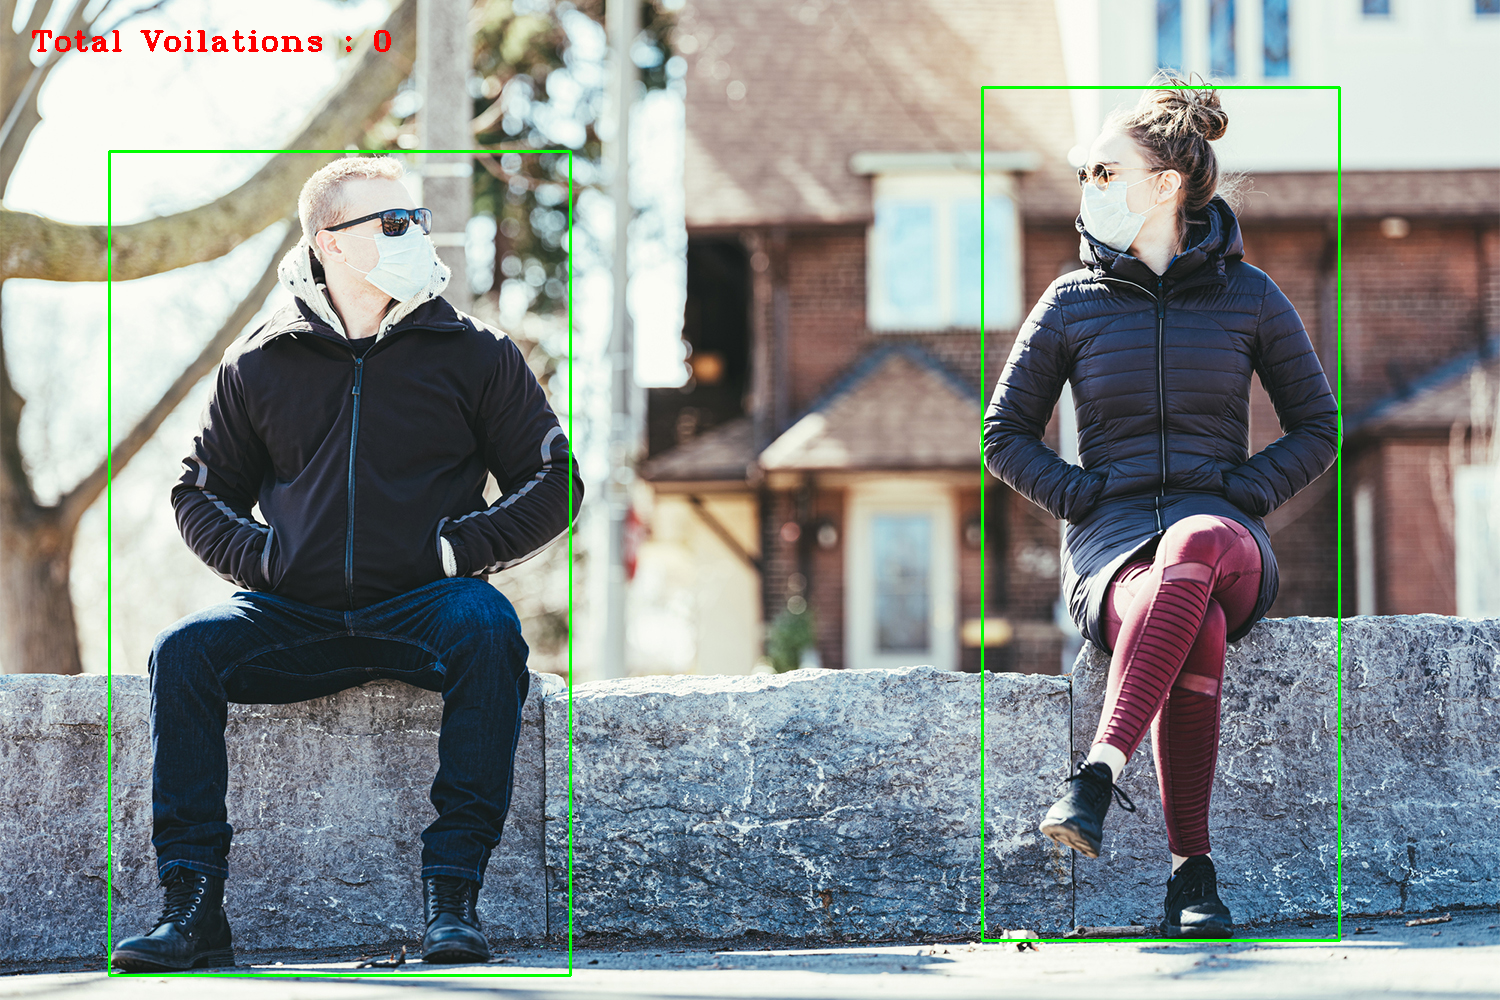

In [ ]:
image = '/content/GettyImages-1214307609-copy.jpg'
euclideanDistance(cv2.imread(image), 1)